In [1]:
# ======================================================
# AI Diary Project — Emotion Detection (IPD Prototype)
# ======================================================
# This notebook demonstrates:
# 1. Dataset loading and preprocessing
# 2. A baseline ML model (TF-IDF + Logistic Regression)
# 3. A transformer-based prototype (RoBERTa)
# 4. Model evaluation and comparison
#
# NOTE:
# - This is an INTERIM prototype (IPD)
# - Models are trained lightly for feasibility, not optimisation
# ======================================================

# Core system utilities
import os
import glob
from zipfile import ZipFile

# Data handling
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Baseline ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Deep learning / NLP
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Hugging Face dataset helper
from datasets import Dataset

# Disable external logging tools for clean output
os.environ["WANDB_DISABLED"] = "true"


In [3]:
# ======================================================
# Dataset Upload and Extraction
# ======================================================
# This cell allows the GoEmotions dataset ZIP
# to be uploaded and extracted in Google Colab
# ======================================================

from google.colab import files

uploaded = files.upload()

# Extract uploaded ZIP
zip_path = list(uploaded.keys())[0]
os.makedirs("goemotions", exist_ok=True)

with ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("goemotions")




Saving DATA final year .zip to DATA final year  (1).zip


In [5]:
# ======================================================
# Locate and Load Dataset Files
# ======================================================
# This avoids hard-coded paths and makes
# the notebook robust to folder structure
# ======================================================

def find_file(pattern):
    matches = glob.glob(pattern, recursive=True)
    if not matches:
        raise FileNotFoundError(f"No file found for pattern: {pattern}")
    return matches[0]

# Locate required files
train_path = find_file("goemotions/**/train.tsv")
emotions_path = find_file("goemotions/**/emotions.txt")

# Load training data
train_df = pd.read_csv(
    train_path,
    sep="\t",
    names=["text", "labels", "id"]
)

# Load emotion label names
with open(emotions_path, encoding="utf-8") as f:
    emotions = [line.strip() for line in f if line.strip()]

print("samples:", len(train_df))
print("Emotion categories:", len(emotions))


samples: 43410
Emotion categories: 28


In [7]:
# ======================================================
# Dataset Subsampling (IPD Justification)
# ======================================================
# A reduced subset is used to:
# - Keep runtime manageable
# - Demonstrate feasibility rather than optimisation
# ======================================================

train_small = train_df.sample(5000, random_state=42).reset_index(drop=True)
NUM_EMOTIONS = len(emotions)

print("Subset size :", len(train_small))


Subset size : 5000


In [8]:
# ======================================================
# Label Encoding (Multi-label → Multi-hot)
# ======================================================
# Converts comma-separated label strings into
# fixed-length binary vectors
# ======================================================

def encode_labels(label_string):
    vector = np.zeros(NUM_EMOTIONS)
    for label in str(label_string).split(","):
        if label.isdigit():
            vector[int(label)] = 1
    return vector

train_small["label_vector"] = train_small["labels"].apply(encode_labels)


In [9]:
# ======================================================
# Train/Test Split
# ======================================================
# Ensures reproducible evaluation
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    train_small["text"],
    np.stack(train_small["label_vector"]),
    test_size=0.2,
    random_state=42
)


In [10]:
# ======================================================
# Baseline Model — TF-IDF Vectorisation
# ======================================================
# Transforms text into numerical features
# using word frequency statistics
# ======================================================

tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF feature shape:", X_train_tfidf.shape)


TF-IDF feature shape: (4000, 10000)


In [11]:
# ======================================================
# Baseline Model — Logistic Regression
# ======================================================
# Uses One-vs-Rest strategy for multi-label classification
# ======================================================

logistic_model = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, solver="liblinear")
)

logistic_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred_baseline = logistic_model.predict(X_test_tfidf)

# Evaluate performance
baseline_macro_f1 = f1_score(y_test, y_pred_baseline, average="macro")
baseline_micro_f1 = f1_score(y_test, y_pred_baseline, average="micro")

print(f"Baseline Macro F1: {baseline_macro_f1:.3f}")
print(f"Baseline Micro F1: {baseline_micro_f1:.3f}")


Baseline Macro F1: 0.074
Baseline Micro F1: 0.156


In [12]:
# ======================================================
# Tokenisation using RoBERTa
# ======================================================
# Converts raw text into token IDs
# ======================================================

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_ds = Dataset.from_dict({"text": X_train.tolist(), "labels": y_train.tolist()})
test_ds = Dataset.from_dict({"text": X_test.tolist(), "labels": y_test.tolist()})

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch")
test_ds.set_format("torch")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
# ======================================================
# RoBERTa Model Configuration
# ======================================================
# Configured for multi-label emotion classification
# ======================================================

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=NUM_EMOTIONS,
    problem_type="multi_label_classification"
)

training_args = TrainingArguments(
    output_dir="results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,     # Short training for IPD
    save_strategy="no",
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)

    return {
        "macro_f1": f1_score(labels, predictions, average="macro"),
        "micro_f1": f1_score(labels, predictions, average="micro")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()

print("RoBERTa Prototype Performance:", metrics)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1893052109.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.164700


RoBERTa Prototype Performance: {'eval_loss': 0.13692490756511688, 'eval_macro_f1': 0.01975108225108225, 'eval_micro_f1': 0.21190130624092887, 'eval_runtime': 404.1742, 'eval_samples_per_second': 2.474, 'eval_steps_per_second': 0.309, 'epoch': 1.0}


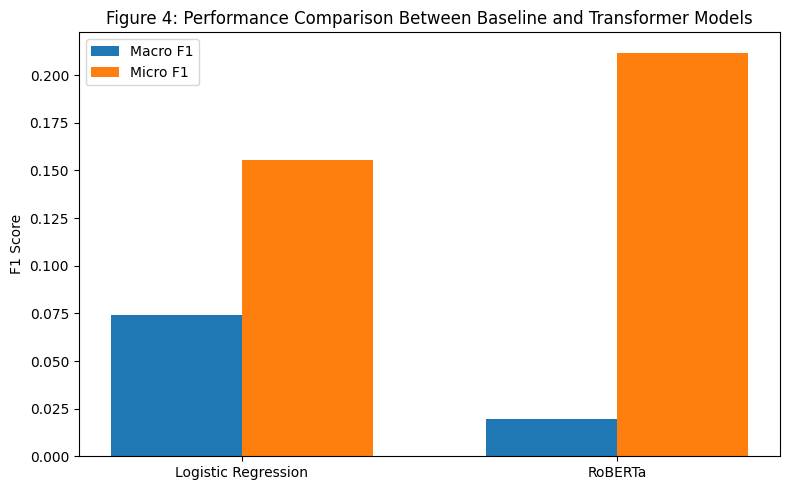

In [14]:
# ======================================================
# Model Performance Comparison
# ======================================================
# Visual comparison between baseline and transformer
# ======================================================

models = ["Logistic Regression", "RoBERTa"]
macro_f1 = [baseline_macro_f1, metrics["eval_macro_f1"]]
micro_f1 = [baseline_micro_f1, metrics["eval_micro_f1"]]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, macro_f1, width, label="Macro F1")
plt.bar(x + width/2, micro_f1, width, label="Micro F1")

plt.xticks(x, models)
plt.ylabel("F1 Score")
plt.title("Figure 4: Performance Comparison Between Baseline and Transformer Models")
plt.legend()
plt.tight_layout()
plt.show()
